# Climate Analysis and Exploration

In [1]:
# Import SQLAlchemy `automap` and other dependencies here
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [4]:
sess = Session(engine)

In [5]:
Base = automap_base()
Base.prepare(engine, reflect=True)

### Look for our tables and grab their information.

In [6]:
Base.classes.keys()

['measurement', 'station']

In [7]:
meas = Base.classes.measurement
station = Base.classes.station

In [8]:
inspector = inspect(engine)

In [9]:
# Inspecting measurement table
for i in inspector.get_columns('measurement'):
    print(i['name'], i['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Inspecting station table
for i in inspector.get_columns('station'):
    print(i['name'], i['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


#### What is the first and last date in my dataset?

In [11]:
sess.query(meas.date).first()

('2010-01-01')

In [12]:
sess.query(meas.date).order_by(meas.date.desc()).first()

('2017-08-23')

### I decide that my trip date started on August 20, 2017 and ended on August 23, 2017.

In [13]:
import datetime as dt

In [14]:
begin_date = dt.date(2017, 8, 20)

In [15]:
end_date = dt.date(2017, 8, 23)

In [16]:
year_from_beg = begin_date - dt.timedelta(days=365)

In [17]:
dates = sess.query(meas.date).filter(meas.date > year_from_beg).all()
prcp = sess.query(meas.prcp).filter(meas.date > year_from_beg).all()

In [18]:
dates = [date[0] for date in dates]

## Precipitation Analysis

In [19]:
prcp_vs_dates_df = pd.DataFrame(prcp, dates)
prcp_vs_dates_df = prcp_vs_dates_df.rename(columns={"prcp": "Precipitation"})
prcp_vs_dates_df.head(10)

,Precipitation
2016-08-21,0.12
2016-08-22,0.40
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00


<IPython.core.display.Javascript object>


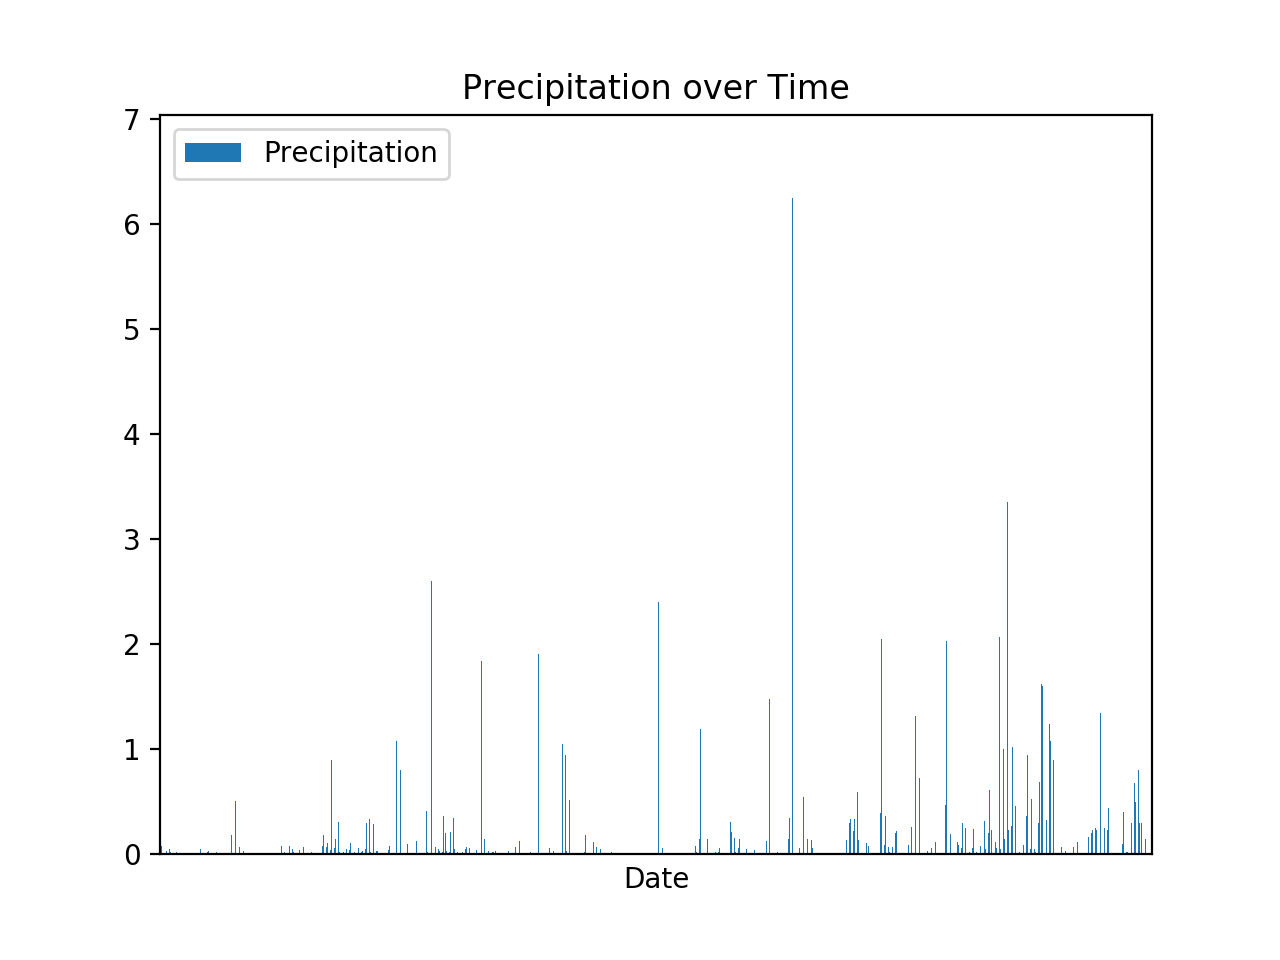

In [20]:
prcp_vs_dates_df.plot.bar(title='Precipitation over Time')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel('Date')
plt.show()

In [21]:
prcp_vs_dates_df.describe()

,Precipitation
count,2031.000000
mean,0.179985
std,0.463894
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

### Total number of stations:

In [22]:
sess.query(station.station).group_by(station.station).count()

9

### Unique stations ordered in descending order based on number of observations made:

In [23]:
sess.query(meas.station, func.count(meas.tobs)).\
    group_by(meas.station).\
    order_by(func.count(meas.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

- Station USC00519281 is the most active station since it has the highest number of observations.

### Last 12 months of temperature observation (TOBS) data prior to start date of excursion:

In [37]:
df_tobs_data = sess.query(meas.id, meas.date, meas.tobs).\
    filter(meas.date > year_from_beg).\
    filter(meas.station == 'USC00519281').all()

In [38]:
import numpy as np
sorted_unique_tobs = np.sort(pd.DataFrame(df_tobs_data)["tobs"].unique())

In [39]:
frequency_unique_tobs = pd.DataFrame(df_tobs_data).groupby("tobs").count()["date"]

<IPython.core.display.Javascript object>


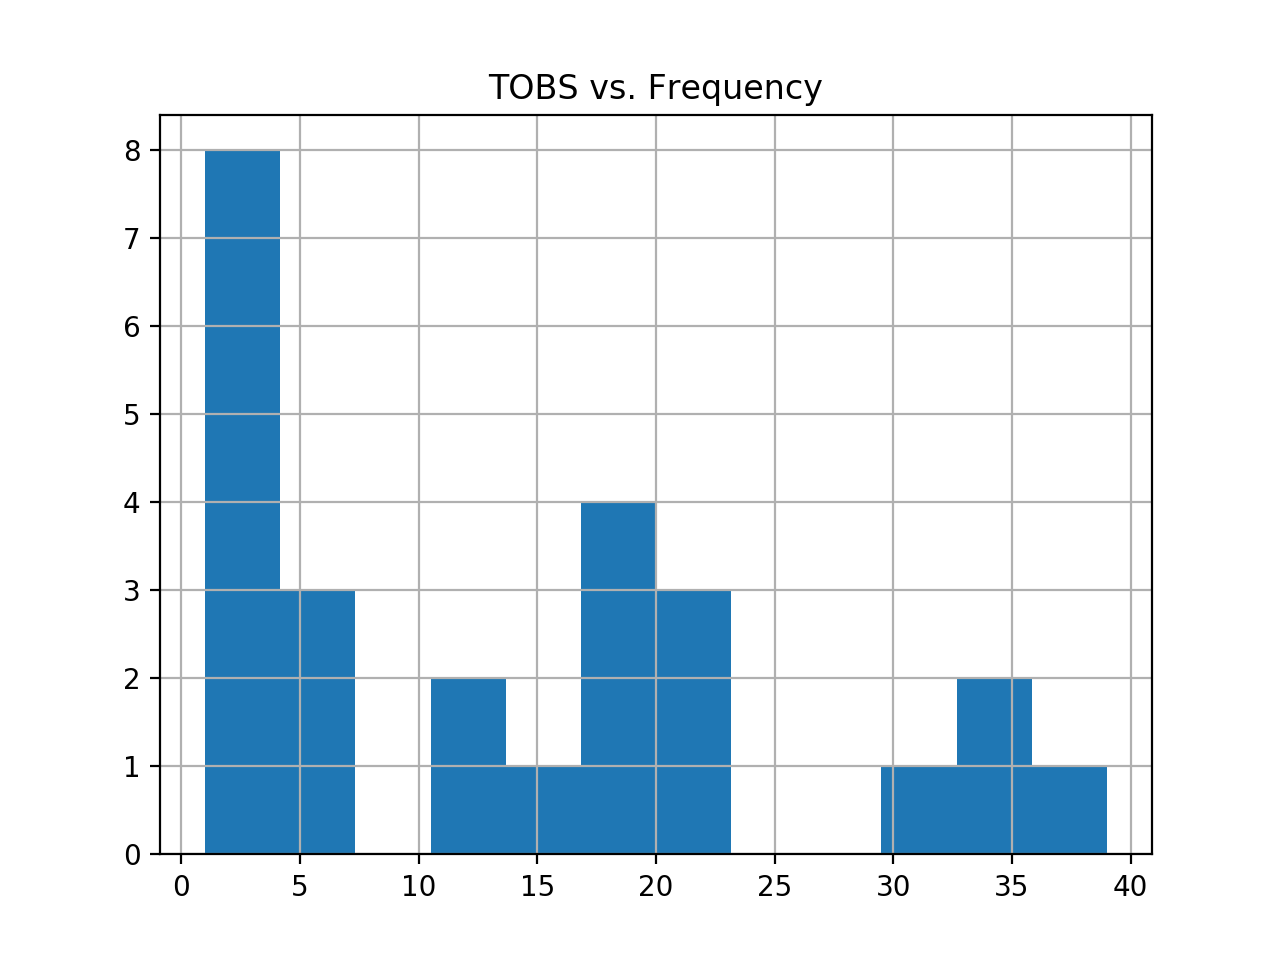

In [41]:
hist_tobs_vs_freq = pd.DataFrame(frequency_unique_tobs, sorted_unique_tobs).reset_index().\
    rename(columns={"index": "Temp Obs", "date": "TOBS vs. Frequency"}).\
    set_index("Temp Obs").hist(bins=12)